In [1]:
from tqdm import tqdm_notebook as tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from scipy.special import softmax

from torchvision import datasets

from torch.utils.data import TensorDataset

from torch.utils.data import DataLoader

import matplotlib.pyplot as plt 

import numpy as np

import pickle

import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [19]:
m_train = 1000
m_test = 1000
n = 10
K = 3

epochs = 200
meaning = 5

In [20]:
class Student(nn.Module):
    def __init__(self, input_dim = n, output_dim = K, device = 'cpu'):
        super(Student, self).__init__()
        
        self.input_dim = input_dim
        self.output_dim = output_dim
        
        self.linear = nn.Linear(input_dim, output_dim)
        
        self.to(device)
        
    def forward(self, input):
        out = self.linear(input)
        return out

Рассмотрим следующий эксперимент

Пусть есть некоторое множество объектов X

Пусть $\mathbf{y} = \text{softmax}(Wx)$ имеет почти равновероятные метки

Сэмплируем класс $y \sim \text{Cat}(\mathbf{y})$

Получаем сильно зашумленную выборку

# Без учителя

In [21]:
np.random.seed(0)

w = np.random.randn(n, K)

X_train = np.random.randn(m_train, n)

v_real = softmax(X_train@w, axis = 1)
y = []
for v in v_real:
    y.append(np.random.choice([0, 1, 2], p = v))
y_train = np.array(y)


X_test = np.random.randn(m_test, n)

v_real = softmax(X_test@w, axis = 1)
y = []
for v in v_real:
    y.append(np.random.choice([0, 1, 2], p = v))
y_test = np.array(y)


In [22]:
X_train_tr = torch.tensor(X_train).float()
X_test_tr = torch.tensor(X_test).float()

y_train_tr = torch.tensor(y_train).long()
y_test_tr = torch.tensor(y_test).long()


In [23]:
train_data = TensorDataset(X_train_tr, y_train_tr)

test_data = TensorDataset(X_test_tr, y_test_tr)

In [24]:
list_of_student_models = []
list_of_acc_train = []
list_of_acc_test = []
list_of_losses_train = []
list_of_losses_test = []

for tryes in tqdm(range(meaning)):

    student = Student()

    optimazir = optim.Adam(student.parameters())
    loss_function = torch.nn.CrossEntropyLoss()

    iterator = tqdm(range(epochs), leave=False)
    iterator.set_postfix_str('epoch 0; loss: train nan test nan; acc: train nan test nan')

    list_of_train_loss = []
    list_of_test_loss = []
    list_of_train_acc = []
    list_of_test_acc = []
    
    for i in iterator:
        dataloader = DataLoader(train_data, batch_size=64, shuffle=True)

        epoch_loss = 0
        epoch_true = 0
        for x, y in dataloader:
            optimazir.zero_grad()

            predict = student(x)

            loss = loss_function(predict, y)

            loss.backward()

            optimazir.step()

            epoch_loss += loss.item()*len(y)
            
            epoch_true += (torch.argmax(predict, axis=1) == y).sum().item()

        testloader = DataLoader(test_data, batch_size=64, shuffle=False)
        test_loss = 0
        test_true = 0
        for x, y in testloader:
            predict = student(x)
            loss = loss_function(predict, y)
            test_loss += loss.item()*len(y)
            
            test_true += (torch.argmax(predict, axis=1) == y).sum().item()

        list_of_train_loss.append(epoch_loss/len(train_data))
        list_of_test_loss.append(test_loss/len(test_data))
        
        list_of_train_acc.append(epoch_true/len(train_data))
        list_of_test_acc.append(test_true/len(test_data))

        iterator.set_postfix_str(
            'epoch {}; loss: train {} test {}; acc: train {} test {}'.format(
                i, 
                round(list_of_train_loss[-1], 2), 
                round(list_of_test_loss[-1], 2), 
                round(list_of_train_acc[-1], 2), 
                round(list_of_test_acc[-1], 2)))
        
    list_of_losses_train.append(list_of_train_loss)
    list_of_losses_test.append(list_of_test_loss)
    
    list_of_acc_train.append(list_of_train_acc)
    list_of_acc_test.append(list_of_test_acc)
    
    list_of_student_models.append(student)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


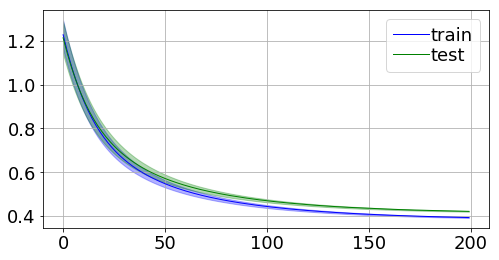

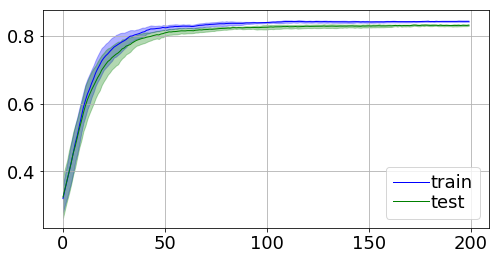

In [25]:
Text_size = 18

plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 4
plt.rcParams['xtick.labelsize'] = Text_size
plt.rcParams['ytick.labelsize'] = Text_size
plt.rcParams['legend.fontsize'] = Text_size
plt.rcParams['axes.titlesize']=Text_size
plt.rcParams['axes.labelsize']=Text_size
plt.rcParams['figure.figsize'] = (8, 4)
plt.rcParams['font.size'] = Text_size
plt.rcParams["legend.labelspacing"] = 0.1
plt.rcParams["legend.handletextpad"] = 0.1
####################################################


mean = np.array(list_of_losses_train).mean(0)
std = np.array(list_of_losses_train).std(0)
x_axis = np.arange(0, len(mean))

plt.plot(x_axis, mean, color = 'blue', label = 'train')
plt.fill_between(x_axis, mean - std, mean + std, alpha = 0.3, color = 'blue')


mean = np.array(list_of_losses_test).mean(0)
std = np.array(list_of_losses_test).std(0)
x_axis = np.arange(0, len(mean))

plt.plot(x_axis, mean, color = 'green', label = 'test')
plt.fill_between(x_axis, mean - std, mean + std, alpha = 0.3, color = 'green')


plt.grid()
plt.legend(loc='best')
plt.show()


mean = np.array(list_of_acc_train).mean(0)
std = np.array(list_of_acc_train).std(0)
x_axis = np.arange(0, len(mean))

plt.plot(x_axis, mean, color = 'blue', label = 'train')
plt.fill_between(x_axis, mean - std, mean + std, alpha = 0.3, color = 'blue')


mean = np.array(list_of_acc_test).mean(0)
std = np.array(list_of_acc_test).std(0)
x_axis = np.arange(0, len(mean))

plt.plot(x_axis, mean, color = 'green', label = 'test')
plt.fill_between(x_axis, mean - std, mean + std, alpha = 0.3, color = 'green')


plt.grid()
plt.legend(loc='best')
plt.show()

In [26]:
list_of_predict = []
testloader = DataLoader(test_data, batch_size=64, shuffle=False)
for x, y in testloader:
    predict = torch.softmax(student(x), -1).detach().numpy()
    list_of_predict.extend(predict)
list_of_predict = np.array(list_of_predict)

v_real = softmax(X_test@w/10, axis = 1)

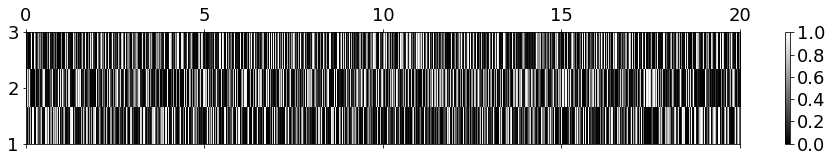

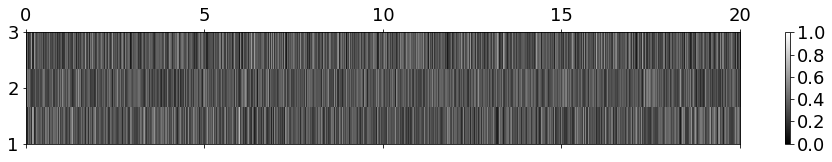

In [27]:
Text_size = 18

plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 4
plt.rcParams['xtick.labelsize'] = Text_size
plt.rcParams['ytick.labelsize'] = Text_size
plt.rcParams['legend.fontsize'] = Text_size
plt.rcParams['axes.titlesize']=Text_size
plt.rcParams['axes.labelsize']=Text_size
plt.rcParams['figure.figsize'] = (4, 2)
plt.rcParams['font.size'] = Text_size
plt.rcParams["legend.labelspacing"] = 0.1
plt.rcParams["legend.handletextpad"] = 0.1
####################################################

im = plt.matshow(list_of_predict.T, 
                 cmap='gray', 
                 interpolation='none', 
                 extent=[0, 20, 1, 3], 
                 aspect="auto",
                 vmin=0.0, vmax=1.0)
_ = plt.colorbar(im)

plt.show()

im = plt.matshow(v_real.T, 
                 cmap='gray', 
                 interpolation='none', 
                 extent=[0, 20, 1, 3], 
                 aspect="auto",
                 vmin=0.0, vmax=1.0)
_ = plt.colorbar(im)

plt.show()

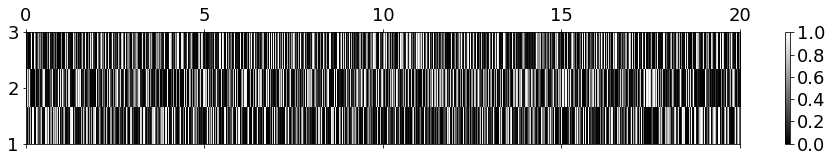

In [28]:
Text_size = 18

plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 4
plt.rcParams['xtick.labelsize'] = Text_size
plt.rcParams['ytick.labelsize'] = Text_size
plt.rcParams['legend.fontsize'] = Text_size
plt.rcParams['axes.titlesize']=Text_size
plt.rcParams['axes.labelsize']=Text_size
plt.rcParams['figure.figsize'] = (8, 4)
plt.rcParams['font.size'] = Text_size
plt.rcParams["legend.labelspacing"] = 0.1
plt.rcParams["legend.handletextpad"] = 0.1
####################################################

im = plt.matshow(list_of_predict.T, 
                 cmap='gray', 
                 interpolation='none', 
                 extent=[0, 20, 1, 3], 
                 aspect="auto",
                 vmin=0.0, vmax=1.0)
_ = plt.colorbar(im)

plt.savefig('./figures/syn_without_teacher_distr.jpg', bbox_inches='tight')

plt.show()

# С учителем

In [29]:
S = softmax(X_train@w/10, axis = 1)

S_tr = torch.tensor(S)


lamb = 0.75

all_train_data = TensorDataset(X_train_tr, y_train_tr, S_tr)

list_of_student_models_dist = []
list_of_acc_train_dist = []
list_of_acc_test_dist = []
list_of_losses_train_dist = []
list_of_losses_test_dist = []



for tryes in tqdm(range(meaning)):

    student = Student()

    optimazir = optim.Adam(student.parameters())
    loss_function = torch.nn.CrossEntropyLoss()

    iterator = tqdm(range(epochs), leave=False)
    iterator.set_postfix_str('epoch 0; loss: train nan test nan; acc: train nan test nan')

    list_of_train_loss = []
    list_of_test_loss = []
    list_of_train_acc = []
    list_of_test_acc = []
    
    for i in iterator:
        dataloader = DataLoader(all_train_data, batch_size=64, shuffle=True)

        epoch_loss = 0
        epoch_true = 0
        for x, y, s in dataloader:
            optimazir.zero_grad()

            predict = student(x)
            log_soft_pred = torch.log(torch.softmax(predict, axis=1))
            
            loss = (1-lamb)*loss_function(predict, y) \
                             - lamb*(s*log_soft_pred).mean() \
#                              - lamb*(log_soft_pred + torch.log(-log_soft_pred)).mean()

            loss.backward()

            optimazir.step()

            epoch_loss += loss.item()*len(y)
            
            epoch_true += (torch.argmax(predict, axis=1) == y).sum().item()

        testloader = DataLoader(test_data, batch_size=64, shuffle=False)
        test_loss = 0
        test_true = 0
        for x, y in testloader:
            predict = student(x)
            loss = loss_function(predict, y)
            test_loss += loss.item()*len(y)
            
            test_true += (torch.argmax(predict, axis=1) == y).sum().item()

        list_of_train_loss.append(epoch_loss/len(train_data))
        list_of_test_loss.append(test_loss/len(test_data))
        
        list_of_train_acc.append(epoch_true/len(train_data))
        list_of_test_acc.append(test_true/len(test_data))

        iterator.set_postfix_str(
            'epoch {}; loss: train {} test {}; acc: train {} test {}'.format(
                i, 
                round(list_of_train_loss[-1], 2), 
                round(list_of_test_loss[-1], 2), 
                round(list_of_train_acc[-1], 2), 
                round(list_of_test_acc[-1], 2)))
        
    list_of_losses_train_dist.append(list_of_train_loss)
    list_of_losses_test_dist.append(list_of_test_loss)
    
    list_of_acc_train_dist.append(list_of_train_acc)
    list_of_acc_test_dist.append(list_of_test_acc)
    
    list_of_student_models_dist.append(student)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:25: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


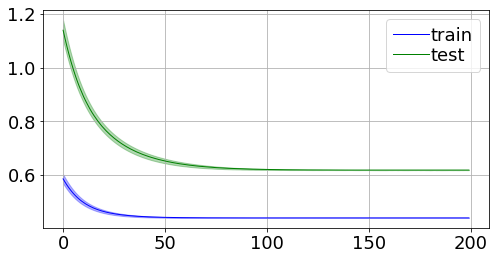

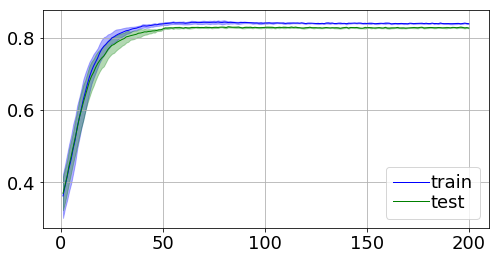

In [30]:
Text_size = 18

plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 4
plt.rcParams['xtick.labelsize'] = Text_size
plt.rcParams['ytick.labelsize'] = Text_size
plt.rcParams['legend.fontsize'] = Text_size
plt.rcParams['axes.titlesize']=Text_size
plt.rcParams['axes.labelsize']=Text_size
plt.rcParams['figure.figsize'] = (8, 4)
plt.rcParams['font.size'] = Text_size
plt.rcParams["legend.labelspacing"] = 0.1
plt.rcParams["legend.handletextpad"] = 0.1
####################################################

mean = np.array(list_of_losses_train_dist).mean(0)
std = np.array(list_of_losses_train_dist).std(0)
x_axis = np.arange(0, len(mean))

plt.plot(x_axis, mean, color = 'blue', label = 'train')
plt.fill_between(x_axis, mean - std, mean + std, alpha = 0.3, color = 'blue')


mean = np.array(list_of_losses_test_dist).mean(0)
std = np.array(list_of_losses_test_dist).std(0)
x_axis = np.arange(0, len(mean))

plt.plot(x_axis, mean, color = 'green', label = 'test')
plt.fill_between(x_axis, mean - std, mean + std, alpha = 0.3, color = 'green')


plt.grid()
plt.legend(loc='best')
plt.show()

mean = np.array(list_of_acc_train_dist).mean(0)
std = np.array(list_of_acc_train_dist).std(0)
x_axis = np.arange(1, len(mean)+1)

plt.plot(x_axis, mean, color = 'blue', label = 'train')
plt.fill_between(x_axis, mean - std, mean + std, alpha = 0.3, color = 'blue')


mean = np.array(list_of_acc_test_dist).mean(0)
std = np.array(list_of_acc_test_dist).std(0)
x_axis = np.arange(1, len(mean)+1)

plt.plot(x_axis, mean, color = 'green', label = 'test')
plt.fill_between(x_axis, mean - std, mean + std, alpha = 0.3, color = 'green')


plt.grid()
plt.legend(loc='best')
plt.show()

In [31]:
np.array(list_of_acc_test).mean(0)[-1]


0.8309999999999998

In [32]:
np.array(list_of_acc_test).std(0)[-1]


0.0018973665961010292

In [33]:
np.array(list_of_acc_test_dist).mean(0)[-1]


0.8273999999999999

In [34]:
np.array(list_of_acc_test_dist).std(0)[-1]


0.001019803902718558

In [15]:
list_of_predict = []
testloader = DataLoader(test_data, batch_size=64, shuffle=False)
for x, y in testloader:
    predict = torch.softmax(student(x), -1).detach().numpy()
    list_of_predict.extend(predict)
list_of_predict = np.array(list_of_predict)

v_real = softmax(X_test@w/10, axis = 1)

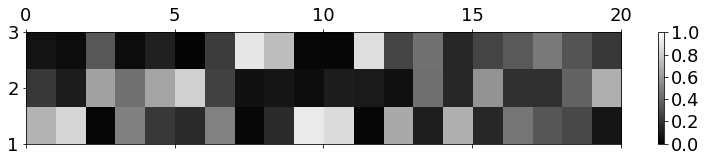

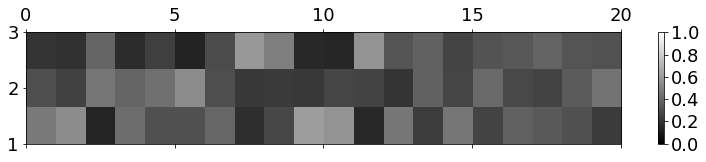

In [16]:
Text_size = 18

plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 4
plt.rcParams['xtick.labelsize'] = Text_size
plt.rcParams['ytick.labelsize'] = Text_size
plt.rcParams['legend.fontsize'] = Text_size
plt.rcParams['axes.titlesize']=Text_size
plt.rcParams['axes.labelsize']=Text_size
plt.rcParams['figure.figsize'] = (4, 2)
plt.rcParams['font.size'] = Text_size
plt.rcParams["legend.labelspacing"] = 0.1
plt.rcParams["legend.handletextpad"] = 0.1
####################################################

im = plt.matshow(list_of_predict.T, 
                 cmap='gray', 
                 interpolation='none', 
                 extent=[0, 20, 1, 3], 
                 aspect="auto",
                 vmin=0.0, vmax=1.0)

_ = plt.colorbar(im)

plt.show()


im = plt.matshow(v_real.T, 
                 cmap='gray', 
                 interpolation='none', 
                 extent=[0, 20, 1, 3], 
                 aspect="auto",
                 vmin=0.0, vmax=1.0)
_ = plt.colorbar(im)

plt.show()

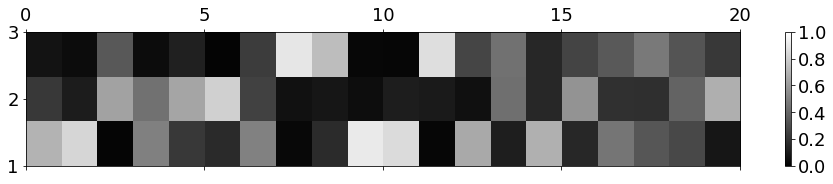

In [17]:
Text_size = 18

plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 4
plt.rcParams['xtick.labelsize'] = Text_size
plt.rcParams['ytick.labelsize'] = Text_size
plt.rcParams['legend.fontsize'] = Text_size
plt.rcParams['axes.titlesize']=Text_size
plt.rcParams['axes.labelsize']=Text_size
plt.rcParams['figure.figsize'] = (8, 4)
plt.rcParams['font.size'] = Text_size
plt.rcParams["legend.labelspacing"] = 0.1
plt.rcParams["legend.handletextpad"] = 0.1
####################################################

im = plt.matshow(list_of_predict.T, 
                 cmap='gray', 
                 interpolation='none', 
                 extent=[0, 20, 1, 3], 
                 aspect="auto",
                 vmin=0.0, vmax=1.0)
_ = plt.colorbar(im)

plt.savefig('./figures/syn_with_teacher_distr.jpg', bbox_inches='tight')

plt.show()

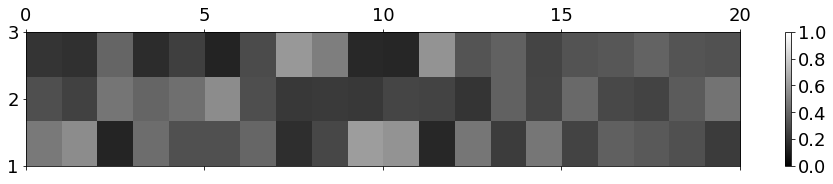

In [18]:
Text_size = 18

plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 4
plt.rcParams['xtick.labelsize'] = Text_size
plt.rcParams['ytick.labelsize'] = Text_size
plt.rcParams['legend.fontsize'] = Text_size
plt.rcParams['axes.titlesize']=Text_size
plt.rcParams['axes.labelsize']=Text_size
plt.rcParams['figure.figsize'] = (8, 4)
plt.rcParams['font.size'] = Text_size
plt.rcParams["legend.labelspacing"] = 0.1
plt.rcParams["legend.handletextpad"] = 0.1
####################################################

im = plt.matshow(v_real.T, 
                 cmap='gray', 
                 interpolation='none', 
                 extent=[0, 20, 1, 3], 
                 aspect="auto",
                 vmin=0.0, vmax=1.0)
_ = plt.colorbar(im)

plt.savefig('./figures/syn_real_distr.jpg', bbox_inches='tight')

plt.show()

# Экперимент, где T и $\lambda$ это параметры

In [21]:
DICT = dict()

for T in tqdm([0.25, 0.5, 1, 2, 4, 8]):
    DICT[T] = dict()
    for lamb in tqdm([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]):
        DICT[T][lamb] = dict()
        S = softmax(X_train@w/T, axis = 1)

        S_tr = torch.tensor(S)

        all_train_data = TensorDataset(X_train_tr, y_train_tr, S_tr)

        list_of_predicts_dist = []
        list_of_student_models_dist = []
        list_of_acc_train_dist = []
        list_of_acc_test_dist = []
        list_of_losses_train_dist = []
        list_of_losses_test_dist = []



        for tryes in tqdm(range(meaning), leave=False):

            student = Student()

            optimazir = optim.Adam(student.parameters())
            loss_function = torch.nn.CrossEntropyLoss()

            iterator = tqdm(range(epochs), leave=False)
            iterator.set_postfix_str('epoch 0; loss: train nan test nan; acc: train nan test nan')

            list_of_predicts= []
            list_of_train_loss = []
            list_of_test_loss = []
            list_of_train_acc = []
            list_of_test_acc = []

            for i in iterator:
                dataloader = DataLoader(all_train_data, batch_size=64, shuffle=True)

                epoch_loss = 0
                epoch_true = 0
                for x, y, s in dataloader:
                    optimazir.zero_grad()

                    predict = student(x)
                    log_soft_pred = torch.log(torch.softmax(predict, axis=1))

                    loss = (1-lamb)*loss_function(predict, y) \
                                     - lamb*(s*log_soft_pred).mean() \
        #                              - lamb*(log_soft_pred + torch.log(-log_soft_pred)).mean()

                    loss.backward()

                    optimazir.step()

                    epoch_loss += loss.item()*len(y)

                    epoch_true += (torch.argmax(predict, axis=1) == y).sum().item()

                testloader = DataLoader(test_data, batch_size=64, shuffle=False)
                test_loss = 0
                test_true = 0
                for x, y in testloader:
                    predict = student(x)
                    loss = loss_function(predict, y)
                    test_loss += loss.item()*len(y)

                    test_true += (torch.argmax(predict, axis=1) == y).sum().item()
                    
                    
                list_of_predict = []
                testloader = DataLoader(test_data, batch_size=64, shuffle=False)
                for x, y in testloader:
                    predict = torch.softmax(student(x), -1).detach().numpy()
                    list_of_predict.extend(predict)
                list_of_predict = np.array(list_of_predict)
                
                list_of_predicts.append(list_of_predict)

                list_of_train_loss.append(epoch_loss/len(train_data))
                list_of_test_loss.append(test_loss/len(test_data))

                list_of_train_acc.append(epoch_true/len(train_data))
                list_of_test_acc.append(test_true/len(test_data))

                iterator.set_postfix_str(
                    'epoch {}; loss: train {} test {}; acc: train {} test {}'.format(
                        i, 
                        round(list_of_train_loss[-1], 2), 
                        round(list_of_test_loss[-1], 2), 
                        round(list_of_train_acc[-1], 2), 
                        round(list_of_test_acc[-1], 2)))

            list_of_losses_train_dist.append(list_of_train_loss)
            list_of_losses_test_dist.append(list_of_test_loss)

            list_of_acc_train_dist.append(list_of_train_acc)
            list_of_acc_test_dist.append(list_of_test_acc)

            list_of_student_models_dist.append(student)
            
            list_of_predicts_dist.append(list_of_predicts)
            
            
        DICT[T][lamb]['list_of_losses_train_dist'] = list_of_losses_train_dist
        DICT[T][lamb]['list_of_losses_test_dist'] = list_of_losses_test_dist
        DICT[T][lamb]['list_of_acc_train_dist'] = list_of_acc_train_dist
        DICT[T][lamb]['list_of_acc_test_dist'] = list_of_acc_test_dist
        DICT[T][lamb]['list_of_student_models_dist'] = list_of_student_models_dist
        DICT[T][lamb]['list_of_predicts_dist'] = list_of_predicts_dist

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:22: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:29: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


KeyboardInterrupt: 

In [28]:
# with open('./dumps/DICT.pkl', 'wb') as f:
#     pickle.dump(DICT, f)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/torch/storage.py:34: FutureWarning: pickle support for Storage will be removed in 1.5. Use `torch.save` instead
  warnings.warn("pickle support for Storage will be removed in 1.5. Use `torch.save` instead", FutureWarning)


In [5]:
with open('./dumps/DICT.pkl', 'rb') as f:
    DICT = pickle.load(f)

In [57]:
mat = np.zeros([6, 11])

for iT, T in enumerate([0.25, 0.5, 1, 2, 4, 8]):
    for ilamb, lamb in enumerate([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]):
        mat[iT, ilamb] = np.mean(DICT[T][lamb]['list_of_predicts_dist'], axis = 0)[-1, 8, 0]

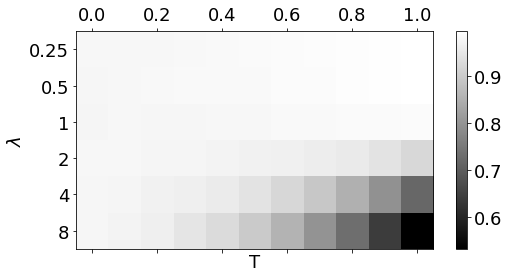

In [58]:
Text_size = 18

plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 4
plt.rcParams['xtick.labelsize'] = Text_size
plt.rcParams['ytick.labelsize'] = Text_size
plt.rcParams['legend.fontsize'] = Text_size
plt.rcParams['axes.titlesize']=Text_size
plt.rcParams['axes.labelsize']=Text_size
plt.rcParams['figure.figsize'] = (8, 4)
plt.rcParams['font.size'] = Text_size
plt.rcParams["legend.labelspacing"] = 0.1
plt.rcParams["legend.handletextpad"] = 0.1
####################################################

ax = plt.gca()
im = ax.matshow(mat, 
                 cmap='gray', 
                 interpolation='none', 
                 aspect="auto",
#                  vmin=0.9, vmax=1.0
                )
_ = plt.colorbar(im)
ax.set_xticklabels([0.0, 0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_yticklabels([0, 0.25, 0.5, 1, 2, 4, 8])

plt.xlabel('T')
plt.ylabel('$\lambda$')

plt.savefig('./figures/syn_T_lambda.eps', bbox_inches='tight')

plt.show()

In [44]:
mat = np.zeros([6, 11])

for iT, T in enumerate([0.25, 0.5, 1, 2, 4, 8]):
    for ilamb, lamb in enumerate([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]):
        mat[iT, ilamb] = np.mean(DICT[T][lamb]['list_of_acc_test_dist'], axis=0)[-1]
        

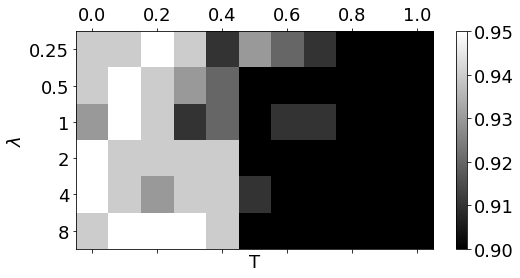

In [56]:
Text_size = 18

plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 4
plt.rcParams['xtick.labelsize'] = Text_size
plt.rcParams['ytick.labelsize'] = Text_size
plt.rcParams['legend.fontsize'] = Text_size
plt.rcParams['axes.titlesize']=Text_size
plt.rcParams['axes.labelsize']=Text_size
plt.rcParams['figure.figsize'] = (8, 4)
plt.rcParams['font.size'] = Text_size
plt.rcParams["legend.labelspacing"] = 0.1
plt.rcParams["legend.handletextpad"] = 0.1
####################################################

ax = plt.gca()
im = ax.matshow(mat, 
                 cmap='gray', 
                 interpolation='none', 
                 aspect="auto",
#                  vmin=0.9, vmax=1.0
                )
_ = plt.colorbar(im)
ax.set_xticklabels([0.0, 0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_yticklabels([0, 0.25, 0.5, 1, 2, 4, 8])

plt.xlabel('T')
plt.ylabel('$\lambda$')

# plt.savefig('./figures/syn_T_lambda.jpg', bbox_inches='tight')

plt.show()

In [42]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [54]:
X = np.array([0.0, 0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
Y = np.array([0, 0.25, 0.5, 1, 2, 4, 8])
X, Y = np.meshgrid(X, Y)
Z = np.array(mat)

In [55]:
Z.shape

(6, 11)

ValueError: shape mismatch: objects cannot be broadcast to a single shape

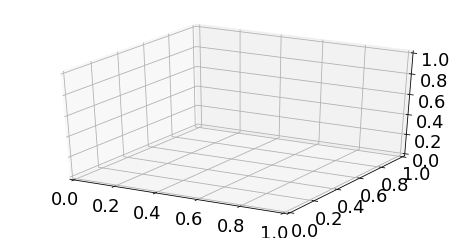

In [50]:
fig = plt.figure()
ax = fig.gca(projection='3d')

surf = ax.plot_surface(X, Y, Z, linewidth=0, antialiased=False)